# Trajectory Tracking Using `loss-landscapes`

This example demonstrates how to track the optimization trajectory of a model during training using the `loss-landscapes` library. Trajectory tracking tools are collected in the `loss_landscapes.trajectories` module.

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from tqdm import tqdm

# import the trajectory tracker
from loss_landscapes.trajectories import ProjectingTrajectoryTracker

matplotlib.rcParams['figure.figsize'] = [17, 11]

The following classes, functions, and constants are set up as preliminaries.

In [5]:
class MLPSmall(torch.nn.Module):
    """ A fully connected feed-forward neural network with one hidden layer. """
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.linear_1 = torch.nn.Linear(x_dim, 32)
        self.linear_2 = torch.nn.Linear(32, y_dim)

    def forward(self, x):
        h = F.relu(self.linear_1(x))
        return F.softmax(self.linear_2(h), dim=1)
    

class Flatten(object):
    """ Transforms a PIL image to a flat numpy array. """
    def __init__(self):
        pass

    def __call__(self, sample):
        return np.array(sample, dtype=np.float32).flatten()
    

# constants
IN_DIM = 28 * 28
OUT_DIM = 10
LR = 10 ** -2
BATCH_SIZE = 512
EPOCHS = 10
STEPS = 40

# download MNIST and setup loaders
mnist_train = datasets.MNIST(root='../data', train=True, download=True, transform=Flatten())
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=False)

## 1. Tracking by Projecting to Random Subspace

Optimization trajectories have `O(mn)` space complexity, where `m` is the number of model parameters and `n` is the number of optimization steps. For large models with hundreds of millions of parameters, such as `ResNet` or `VGG`, storing a full optimization trajectory in memory is intractable.

One solution is to apply dimensionality reduction to the points in parameter space, by projecting to a lower-dimensional subspace. The `ProjectingTrajectoryTracker` class accomplished this. When instantiated, a projecting trajectory tracker samples `n` random points on the unit sphere in parameter space. The vectors from the origin to this point are used as the basis vectors for an `n`-dimensional subspace. The default value is `n = 2` (points in parameter space are projected onto a plane).

In [6]:
# define model
model = MLPSmall(IN_DIM, OUT_DIM)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

# trajectory tracker
tracker = ProjectingTrajectoryTracker(model)

The design philosophy of the trajectory trackers is that the training loop should be external to the tracker, in order to easily accommodate any training procedure. When the client code wishes to store the model state into the optimization trajectory history, it does so by calling `save_position`.

In [7]:
# training loop
for _ in tqdm(range(EPOCHS), 'Training'):
    for count, batch in enumerate(train_loader, 0):
        optimizer.zero_grad()
        x, y = batch

        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        
        # store value after updating
        tracker.save_position(model)

Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.03s/it]


The trajectory, projected onto a plane in parameter space, can easily be visualized as a plot.

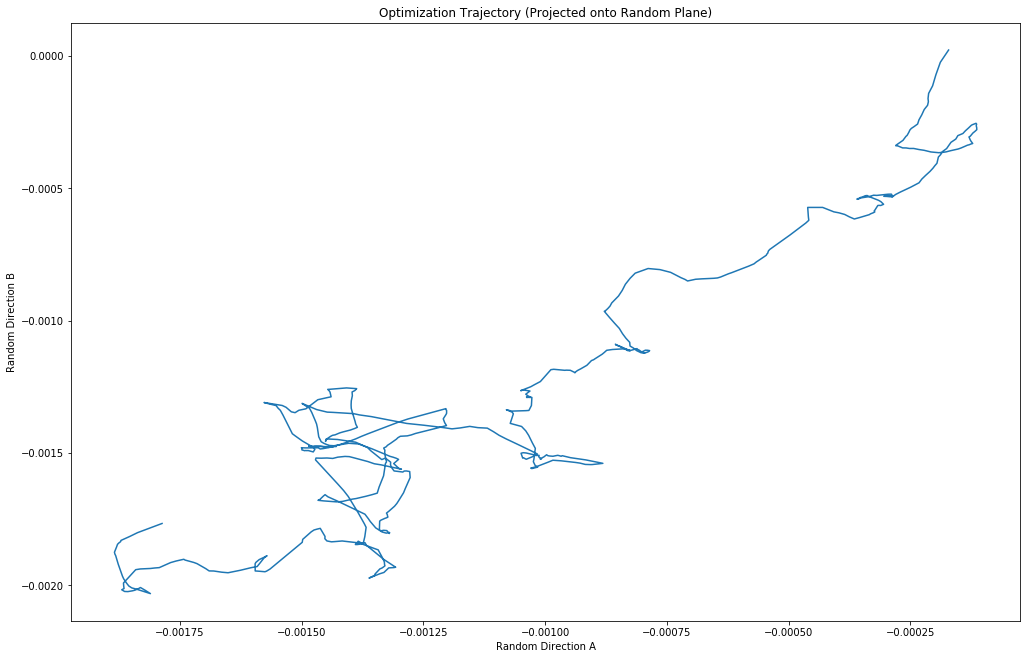

In [8]:
x, y = np.transpose(tracker.get_trajectory())
plt.plot(x, y)
plt.title('Optimization Trajectory (Projected onto Random Plane)')
plt.xlabel('Random Direction A')
plt.ylabel('Random Direction B')
plt.show()

Note that the erratic appearance of the optimization trajectory, as well as the small variance along either basis vector, are artefacts of projecting to a random plane. The plane is very likely to be approximately normal to the real optimization trajectory. Plots generated using this technique are unlikely to be particularly informative.

## 2. Tracking Full Trajectories

A better solution to the space complexity problem is to spill the stored optimization trajectory from main memory into storage. This feature will be soon implemented.